In [122]:
import os
import datetime 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [284]:
df = pd.read_csv(f'{os.getcwd()}/pm_wiki.csv',parse_dates=['ds'])

In [196]:
class Seasonality:
    def __init__(self,df):
        self.df = df
    
    def parse_dates(self):
        self.df['year'] = self.df['ds'].dt.year
        self.df['monthofyear'] = self.df['ds'].dt.month
        self.df['dayofmonth'] = self.df['ds'].dt.day
        self.df['dayofweek'] = self.df['ds'].dt.dayofweek
        self.df['weekofyear'] = self.df['ds'].dt.isocalendar().week
    
    def get_averages(self):
        self.df['year_avg'] = self.df.groupby('year')['y'].transform('mean')
        self.df['monthofyear_avg'] = self.df.groupby(['year','monthofyear'])['y'].transform('mean')
        self.df['dayofmonth_avg'] = self.df.groupby(['year','dayofmonth'])['y'].transform('mean')
        self.df['dayofweek_avg'] = self.df.groupby(['year','weekofyear','dayofweek'])['y'].transform('mean')
        self.df['weekofyear_avg'] = self.df.groupby(['year','weekofyear'])['y'].transform('mean')

    def calc_seasonality(self):
        self.df['monthofyear_seasonality'] = self.df['monthofyear_avg'] / self.df['year_avg']
        self.df['dayofmonth_seasonality'] = self.df['dayofmonth_avg'] / self.df['year_avg']
        self.df['dayofweek_seasonality'] = self.df['dayofweek_avg'] / self.df['weekofyear_avg']
    
    def calc_monthofyear_seasonality(self):
        weights = {
            2013: 0.1,
            2014: 0.2,
            2015: 0.7,
        }
        df = self.df[self.df['year'].isin(weights.keys())]
        monthofyear_seasonality = df.groupby(['year','monthofyear'])[['monthofyear_seasonality']].mean()\
            .reset_index(drop=False)\
            .pivot(columns='year',index='monthofyear',values='monthofyear_seasonality')\
            .apply(lambda x: x * weights[x.name])\
            .sum(axis=1)

        display(monthofyear_seasonality)
        self.monthofyear_seasonality = monthofyear_seasonality
    
    def calc_dayofmonth_seasonality(self):
        weights = {
            2013: 0.1,
            2014: 0.2,
            2015: 0.7,
        }
        df = self.df[self.df['year'].isin(weights.keys())]
        dayofmonth_seasonality = df.groupby(['year','dayofmonth'])[['dayofmonth_seasonality']].mean()\
            .reset_index(drop=False)\
            .pivot(columns='year',index='dayofmonth',values='dayofmonth_seasonality')\
            .apply(lambda x: x * weights[x.name])\
            .sum(axis=1)
        
        display(dayofmonth_seasonality)
        self.dayofmonth_seasonality = dayofmonth_seasonality
    
    def calc_dayofweek_seasonality(self):
        week_lookback = 25
        max_date = self.df.ds.max()
        end_date = max_date - datetime.timedelta(days=max_date.weekday())
        start_date = end_date - datetime.timedelta(days=week_lookback*7)

        df = self.df[(self.df.ds >= start_date)&(self.df.ds < end_date)]
        dayofweek_seasonality = df.groupby(['year','weekofyear','dayofweek'])[['dayofweek_seasonality']].mean()\
            .reset_index(drop=False)\
            .pivot(columns=['year','weekofyear'],index='dayofweek',values='dayofweek_seasonality')\
            .mean(axis=1)
        
        display(dayofweek_seasonality)
        self.dayofweek_seasonality = dayofweek_seasonality


In [197]:
szn = Seasonality(df)

In [198]:
szn.parse_dates()

In [199]:
szn.get_averages()

In [200]:
szn.calc_seasonality()

In [201]:
szn.calc_monthofyear_seasonality()

monthofyear
1     1.136062
2     1.034388
3     0.954877
4     0.930663
5     0.940634
6     0.897880
7     0.917017
8     0.965984
9     1.074724
10    1.047209
11    1.060661
12    1.044401
dtype: float64

In [202]:
szn.calc_dayofmonth_seasonality()

dayofmonth
1     1.013218
2     1.016093
3     1.004264
4     1.004853
5     0.989265
6     1.002279
7     0.981738
8     0.986924
9     0.997433
10    0.991120
11    1.003316
12    1.006157
13    1.010798
14    0.992552
15    0.990819
16    1.007434
17    0.991080
18    1.003113
19    1.002156
20    1.005769
21    1.009752
22    1.001279
23    0.994991
24    0.996629
25    0.991152
26    0.975654
27    1.001823
28    0.998463
29    1.010293
30    1.031986
31    0.983259
dtype: float64

In [203]:
szn.calc_dayofweek_seasonality()

dayofweek
0    1.067626
1    1.025229
2    0.983354
3    0.984169
4    0.994467
5    0.936580
6    1.008232
dtype: float64

<Axes: >

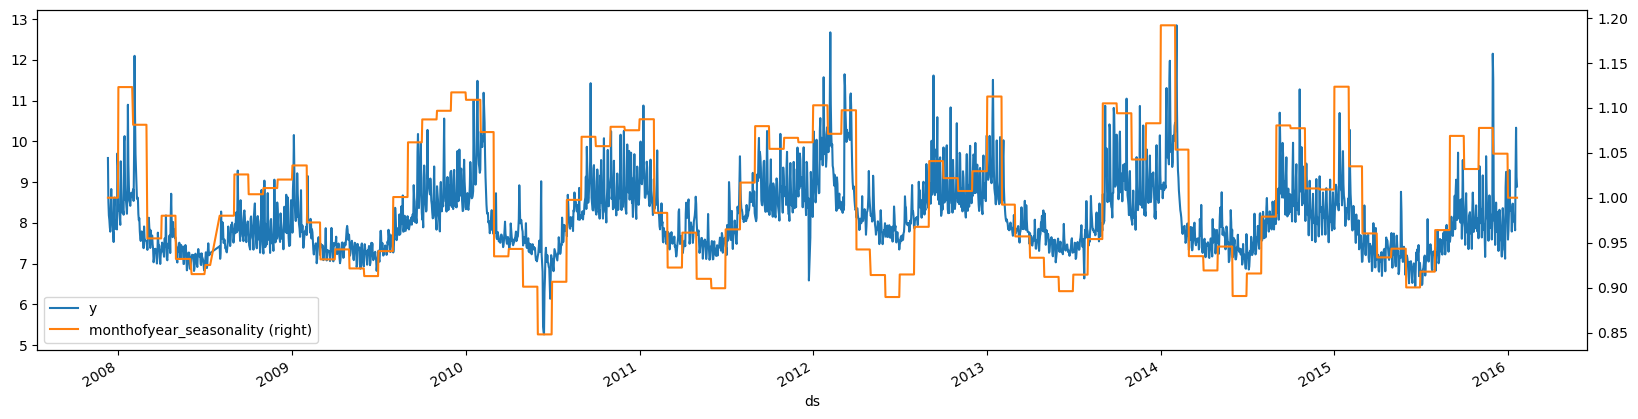

In [212]:
fig, ax = plt.subplots()
szn.df.plot(ax=ax,x='ds',y='y',figsize=(20,5))
szn.df.plot(ax=ax,x='ds',y='monthofyear_seasonality',secondary_y=True,figsize=(20,5))
# szn.df.plot(ax=ax,x='ds',y='dayofweek_seasonality',secondary_y=True,figsize=(20,5))

<Axes: >

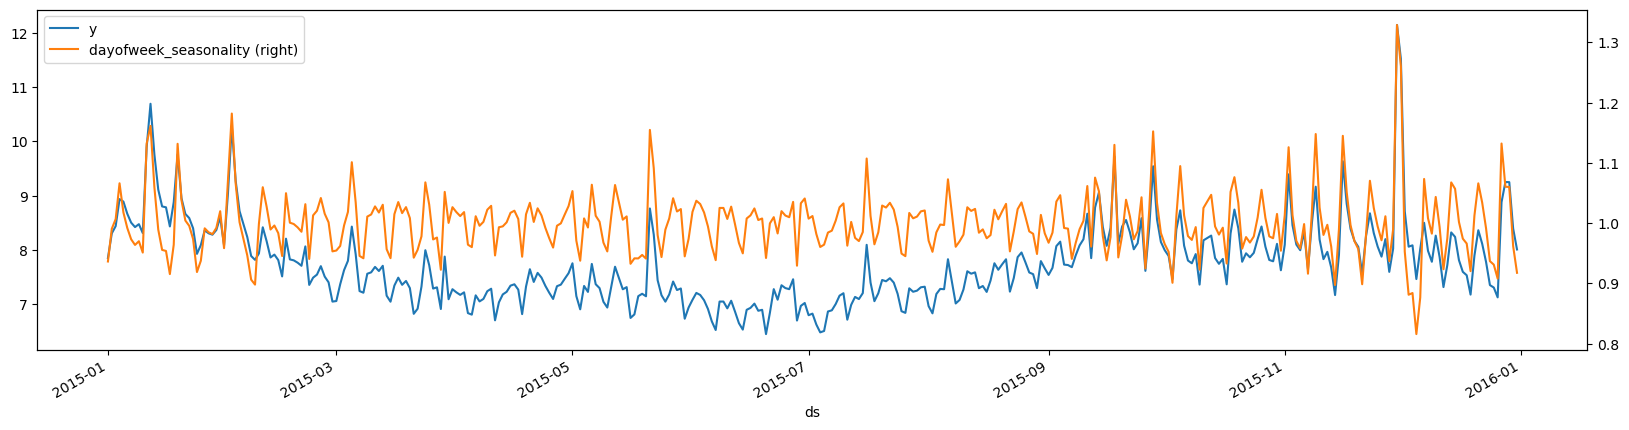

In [213]:
fig, ax = plt.subplots()
df = szn.df[szn.df['year'] == 2015]
df.plot(ax=ax,x='ds',y='y',figsize=(20,5))
df.plot(ax=ax,x='ds',y='dayofweek_seasonality',secondary_y=True,figsize=(20,5))

<Axes: >

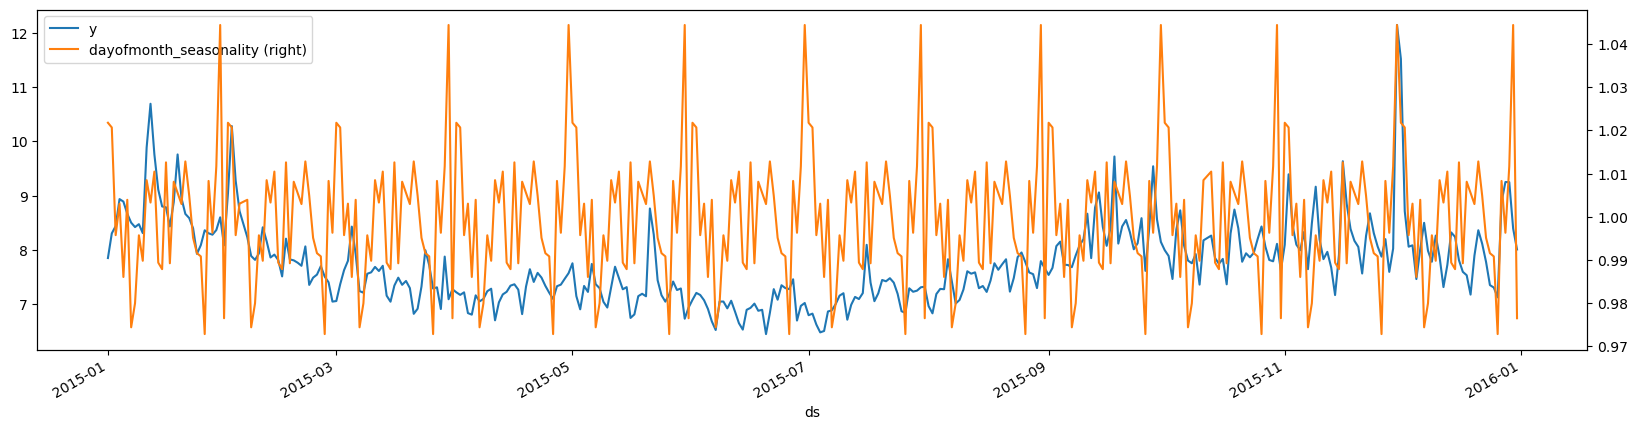

In [215]:
fig, ax = plt.subplots()
df = szn.df[szn.df['year'] == 2015]
df.plot(ax=ax,x='ds',y='y',figsize=(20,5))
df.plot(ax=ax,x='ds',y='dayofmonth_seasonality',secondary_y=True,figsize=(20,5))

In [255]:
base_avg = szn.df[szn.df['year'] == 2014]['y'].mean()

In [272]:
start_date = datetime.datetime(2015,1,1)
end_date = szn.df.ds.max()
dates = pd.date_range(start_date,end_date,freq='D')
data = {}
for date in dates:
    # print(date.date())
    expected_views = base_avg \
        * szn.monthofyear_seasonality[date.month]\
        * szn.dayofweek_seasonality[date.weekday()]\
        * szn.dayofmonth_seasonality[date.day]
    # print(round(expected_views,2))
    data[date] = expected_views
expected_views_df = pd.Series(data,name='expected_views').reset_index().rename(columns={'index':'ds'})

<Axes: xlabel='ds'>

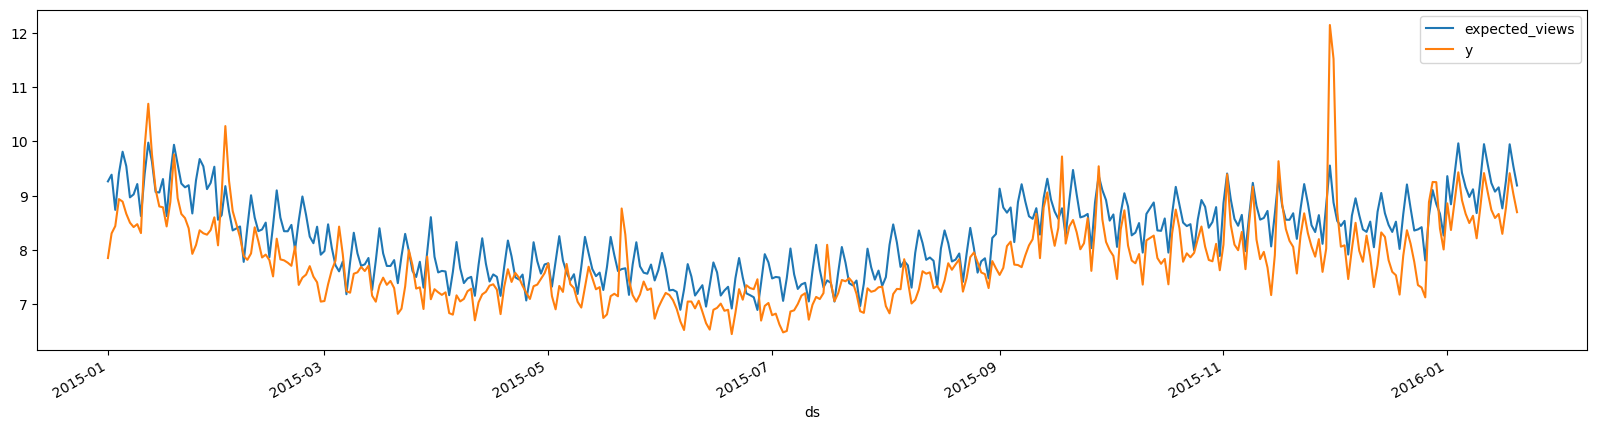

In [273]:
comparison_df = expected_views_df.merge(szn.df[['ds','y']],on=['ds'],how='inner')
comparison_df.plot(x='ds',figsize=(20,5))

In [274]:
mape = comparison_df.apply(lambda x: abs(x['y'] - x['expected_views']) / x['y'],axis=1).mean()
print('Mape with day of month:',round(mape,4))

Mape with day of month: 0.0685


In [270]:
mape = comparison_df.apply(lambda x: abs(x['y'] - x['expected_views']) / x['y'],axis=1).mean()
print('Mape without day of month:',round(mape,4))

Mape without day of month: 0.069


In [290]:
from prophet import Prophet
from itertools import product

In [308]:
class Forecast:
    def __init__(self,df,params):
        self.df = df
        self.params = params
        
        self.periods_fc = 14
        self.main_strt_dt = self.df.ds.max()
        self.test_strt_dt = (self.main_strt_dt - datetime.timedelta(days=self.periods_fc))
        
        self.test_model = None
        self.main_model = None
        
        self.test_fc = None
        self.main_fc = None

        self.mape = None
        
        # self.lockdowns = pd.DataFrame([
        #     {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
        #     {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
        #     {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
        #     {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
        # ])
        # for t_col in ['ds', 'ds_upper']:
        #     self.lockdowns[t_col] = pd.to_datetime(self.lockdowns[t_col])
        # self.lockdowns['upper_window'] = (self.lockdowns['ds_upper'] - self.lockdowns['ds']).dt.days
    
    def run(self,run_type):        
        if run_type == 'test':
            train_df = self.df.loc[self.df.ds<=self.test_strt_dt]
        elif run_type == 'main':
            train_df = self.df.loc[self.df.ds<=self.main_strt_dt]
        
        model = Prophet(**self.params)
        model.add_country_holidays(country_name='US')
        model.fit(train_df)
        future = model.make_future_dataframe(periods=self.periods_fc,include_history=False)
        setattr(self,f'{run_type}_fc',model.predict(future))
        setattr(self,f'{run_type}_model',model)
    
    def compile(self):
        self.fc = pd.concat([
            self.df.loc[self.df.ds<=self.test_strt_dt],
            self.test_fc.merge(self.df,how='inner',on='ds'),
            self.main_fc
        ],axis=0)
    
    def calc_mape(self):
        self.mape = self.fc.apply(lambda x: abs(x['y'] - x['yhat']) / x['y'],axis=1).mean()
    
    def graph(self):
        plt.style.use('fivethirtyeight') # ggplot, fivethirtyeight, tableau-colorblind10, grayscale

        fig, ax1 = plt.subplots(figsize=(12,6))
        fig.suptitle('Peyton Manning Wikipedia Traffic', fontsize=18) # fontweight='bold'
        fig.tight_layout()
        ax1.grid(True)
        
        forecast_df = self.fc.loc[self.fc.ds>=self.test_strt_dt]
        ax1.plot(forecast_df.ds,forecast_df.y,color='#091d63',label='Y',linewidth=2)
        ax1.plot(forecast_df.ds,forecast_df.yhat,color='#630909',linestyle='--',label='Yhat',linewidth=2)
        ax1.plot(forecast_df.ds,forecast_df.yhat_lower,color='#000000',linestyle=':',label='Yhat Lower',linewidth=2)
        ax1.plot(forecast_df.ds,forecast_df.yhat_upper,color='#000000',linestyle=':',label='Yhat Upper',linewidth=2)
        ax1.set_xlabel('Date',fontsize=10)
        ax1.set_ylabel('Views',fontsize=10)
        ax1.legend(loc='upper left')
        
        ax1.xaxis.set_tick_params(rotation=45)
        plt.figtext(0,-0.2,f'Data up to {self.main_strt_dt.strftime("%Y-%m-%d")}',fontsize=10)
        
        self.main_model.plot_components(self.main_fc);

In [311]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_range': [0.8, 0.85, 0.875, 0.9, 0.95],
    # 'growth': ['linear','logistic'],
}
combinations = list(product(*param_grid.values()))
param_combinations = [dict(zip(param_grid.keys(), combination)) for combination in combinations]

In [312]:
best_mape = 100
best_params = None
best_forecast = None
mapes = []

for params in param_combinations:
    fc = Forecast(df,params)
    fc.run('test')
    fc.run('main')
    fc.compile()
    fc.calc_mape()
    mapes.append(fc.mape)
    if fc.mape < best_mape:
        best_mape = fc.mape
        best_params = params
        best_forecast = fc

12:44:05 - cmdstanpy - INFO - Chain [1] start processing
12:44:05 - cmdstanpy - INFO - Chain [1] done processing
12:44:05 - cmdstanpy - INFO - Chain [1] start processing
12:44:05 - cmdstanpy - INFO - Chain [1] done processing
12:44:05 - cmdstanpy - INFO - Chain [1] start processing
12:44:06 - cmdstanpy - INFO - Chain [1] done processing
12:44:06 - cmdstanpy - INFO - Chain [1] start processing
12:44:06 - cmdstanpy - INFO - Chain [1] done processing
12:44:06 - cmdstanpy - INFO - Chain [1] start processing
12:44:06 - cmdstanpy - INFO - Chain [1] done processing
12:44:07 - cmdstanpy - INFO - Chain [1] start processing
12:44:07 - cmdstanpy - INFO - Chain [1] done processing
12:44:07 - cmdstanpy - INFO - Chain [1] start processing
12:44:07 - cmdstanpy - INFO - Chain [1] done processing
12:44:08 - cmdstanpy - INFO - Chain [1] start processing
12:44:08 - cmdstanpy - INFO - Chain [1] done processing
12:44:08 - cmdstanpy - INFO - Chain [1] start processing
12:44:08 - cmdstanpy - INFO - Chain [1]

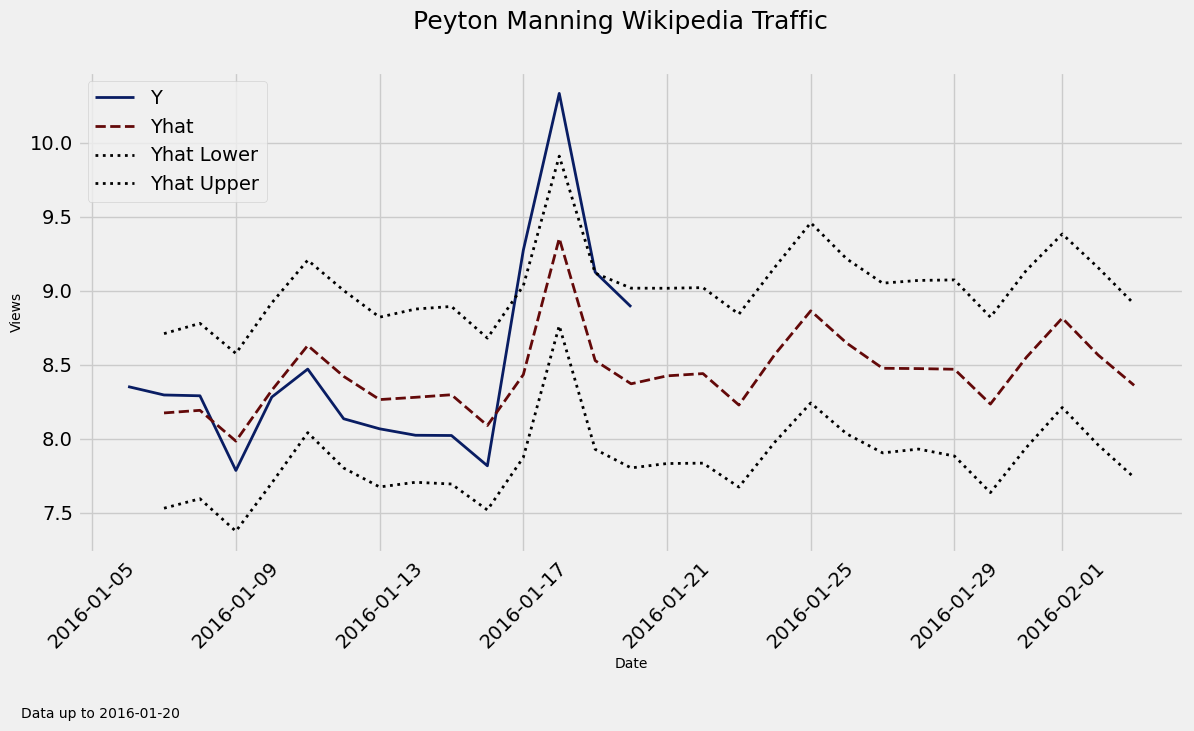

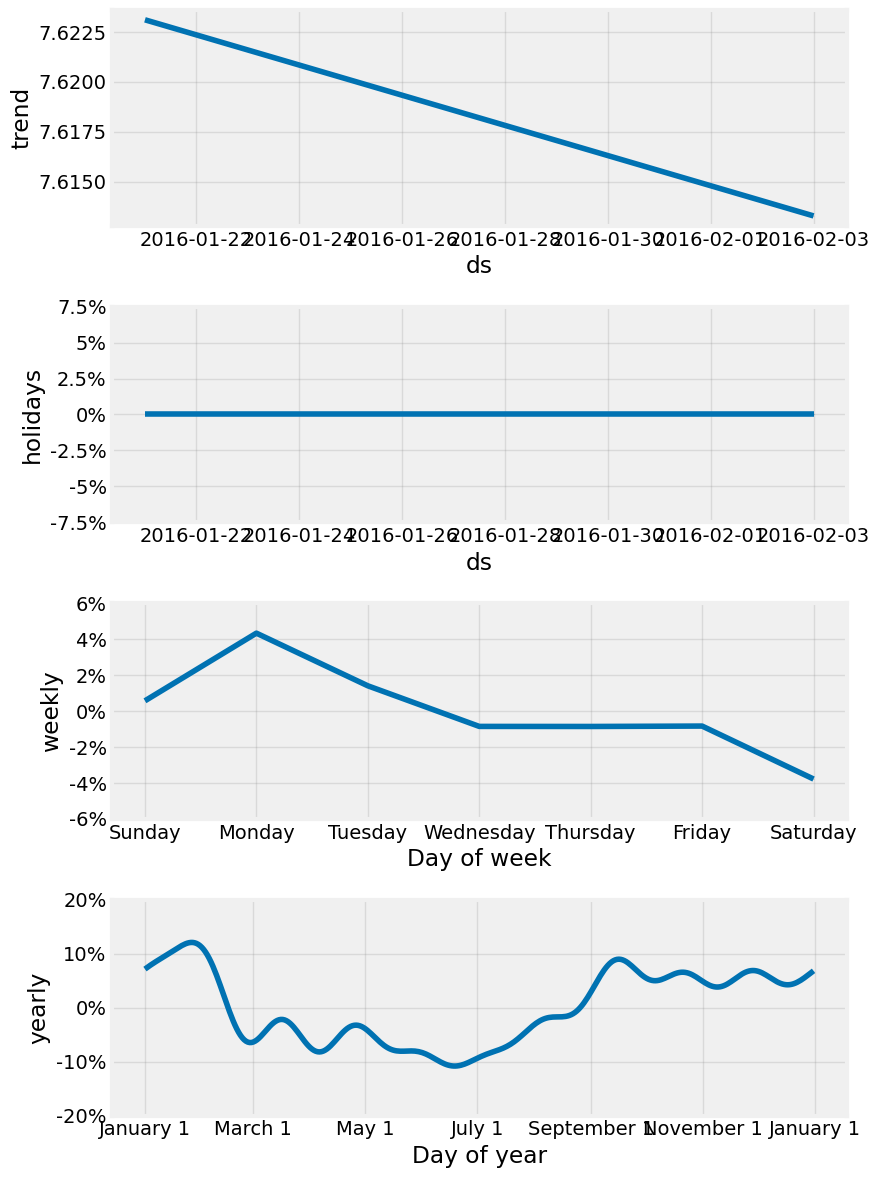

In [313]:
best_forecast.graph()